### Protein Grouping based on AlphaDIA output

Start from psm.tsv output & implement protein grouping:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Use the index of psm_table as peptide IDs for easier lookup; otherwise, the unique identifier for a precursor is the precursor_idx. Generate a dataframe `protein_table` with a `proteins` and  `peptides` column, where the latter contains sets of all peptides belonging to a certain protein. Generate a lookup list containing all peptide indices, and a boolean state vector of the same length to indicate whether this peptide has been taken by a protein. 

- 1.: Identify proteotypic precursors --> this has an issue for now, proteins apparently only contains protein ambiguity groups (e.g. isoforms)
- 2.: Merge all proteins in `protein_table` if their peptides are identical.
- 3.: Merge all proteins in `protein_table` into ambiguity groups if their peptides are subsets of each other
- 4.: Use greedy set cover to assign peptides to proteins by the razor principle & maximum parsimony

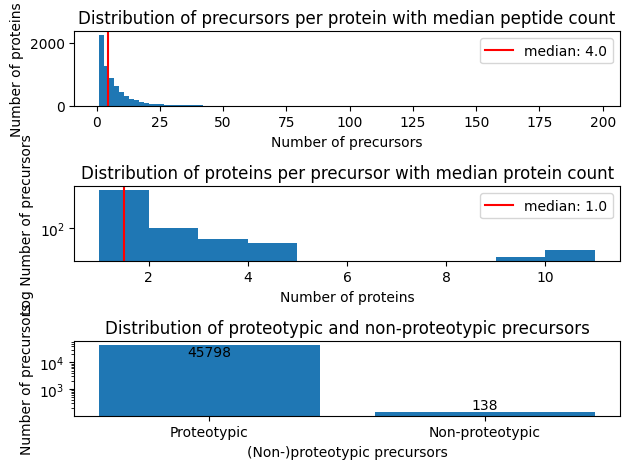

In [261]:
#retrieve psm.tsv output table
precursor_table = pd.read_csv("./../../../../data/processed/psm.tsv", sep = "\t")

#Generate dataframe where each row is a protein and the peptides are in a set
protein_table = precursor_table.groupby("proteins").apply(lambda x : set(x.index)).reset_index(name = "peptides")
protein_table.sort_values(by = "peptides", key = lambda x : x.str.len(), ascending = False, inplace = True)

#Convert csv protein names to set
precursor_table["proteins_set"] = precursor_table.proteins.apply(lambda x : set(x.split(";")))
precursor_table.sort_values(by = "proteins_set", key = lambda x : x.str.len(), ascending = False, inplace = True)

#Add proteotypicity column
precursor_table["proteotypic"] = precursor_table.proteins_set.apply(lambda x : len(x) == 1)

#visualize distribution of peptide counts per protein and proteins per peptide
fig, ax = plt.subplots(3, 1)
ax[0].hist(protein_table.peptides.str.len(), bins = 100, log = False)
ax[0].set_xlabel("Number of precursors")
ax[0].set_ylabel("Number of proteins")
ax[0].axvline(protein_table.peptides.str.len().median() + 0.5, color = "red", label = f"median: {protein_table.peptides.str.len().median()}")
ax[0].set_title("Distribution of precursors per protein with median peptide count")
ax[0].legend()
ax[1].hist(precursor_table.proteins_set.str.len(), bins = 10, log = True)
ax[1].set_xlabel("Number of proteins")
ax[1].set_ylabel("Log Number of precursors")
ax[1].axvline(precursor_table.proteins_set.str.len().median() + 0.5, color = "red", label = f"median: {precursor_table.proteins_set.str.len().median()}")
ax[1].set_title("Distribution of proteins per precursor with median protein count")
ax[1].legend()
ax[2].bar(["Proteotypic", "Non-proteotypic"], [precursor_table.proteotypic.sum(), np.abs((~precursor_table.proteotypic).sum())], log = True)
ax[2].set_title("Distribution of proteotypic and non-proteotypic precursors")
#label bars with counts
for i, v in enumerate([precursor_table.proteotypic.sum(), np.abs((~precursor_table.proteotypic).sum())]):
    alignment = ["top" if v > 1000 else "bottom"][0]
    ax[2].text(i, v, str(v), ha = "center", va = alignment)
ax[2].set_xlabel("(Non-)proteotypic precursors")
ax[2].set_ylabel("Number of precursors")
fig.tight_layout()

plt.show()

In [262]:
def strict_protein_grouping(
    precursor_table: pd.DataFrame,
    graphical_output: bool = False
    ):

    """Function to perform parsimonious protein grouping
    Args:
        precursor_table: long table where rows are precursors with continuous indices and a "proteins" column contains semicolon-separated strings of protein names
    """

    import pandas as pd
    import numpy as np
    from tqdm import tqdm
    if graphical_output:
        raise NotImplementedError("Graphical output not implemented yet")
        import matplotlib.pyplot as plt

    #exclude decoys
    precursor_table = precursor_table[precursor_table.decoy == 0]
    precursor_table = precursor_table.reset_index(drop = True)

    #Record proteotypic precursors
    precursor_table["protein_set"] = precursor_table.proteins.apply(lambda x : set(x.split(";")))
    precursor_table = precursor_table.sort_values(by = "protein_set", key = lambda x : x.str.len(), ascending = False)
    precursor_table["proteotypic"] = precursor_table.protein_set.apply(lambda x : len(x) == 1)
    
    #compile set of all peptide indices & create lookup array for peptide indices
    peptide_indices = set(precursor_table.index)
    peptide_lookup = np.ones(len(peptide_indices), dtype = bool)

    #protein dataframe: repeated rows for each protein that belongs to a peptide
    protein_table = {"protein": [], "peptide": []}
    for i, row in precursor_table.iterrows():
        peptide_index = i
        proteins = row["protein_set"]
        for protein in proteins:
            protein_table["peptide"].append(peptide_index)
            protein_table["protein"].append(protein)
    protein_table = pd.DataFrame(protein_table).groupby("protein").apply(lambda x : set(x.peptide)).reset_index(name = "peptides")
    
    #GROUPING: summarize proteins with identical peptide sets into protein groups and remove duplicated rows --> now, each row is a protein group
    protein_table["peptide_set_string"] = protein_table.peptides.apply(lambda x : ";".join([str(i) for i in sorted(list(x))]))
    protein_table["protein"] = protein_table.groupby("peptide_set_string")["protein"].transform(lambda x : ";".join(x))
    protein_table = protein_table.drop_duplicates(subset = "protein").reset_index(drop = True)

    #Iterate over protein_table and remove peptides from lookup array as they are assigned to a new group
    new_protein_table = {}
    with tqdm(total = protein_table.shape[0]) as pbar:
        pbar.set_description("Protein grouping")
        for i in range(protein_table.shape[0]):    
            #check lookup array if current query peptides are taken & update lookup array & save new group
            query_protein = protein_table.iloc[0]["protein"]
            query_peptides = np.array(list(protein_table.iloc[0]["peptides"]), dtype = np.int64)

            keep_peptides = query_peptides[peptide_lookup[query_peptides]]
            peptide_lookup[keep_peptides] = False
            new_protein_table[query_protein] = keep_peptides

            #costly updating part: update each set in protein_table[peptides] to remove peptide indices that are in keep_set & resort
            protein_table.peptides = protein_table.peptides.apply(lambda x : set(x).difference(set(keep_peptides)))
            protein_table = protein_table.sort_values(by = "peptides", key = lambda x : x.str.len(), ascending = False)

            #update progress bar
            pbar.update(1)
    
    #convert new_protein_table to dataframe
    new_protein_table = pd.DataFrame({
        "protein": list(new_protein_table.keys()),
        "peptides": list(new_protein_table.values())
    }).sort_values(by = "peptides", key = lambda x : x.str.len(), ascending = False)
    return new_protein_table


### To demonstrate how grouping would cut down peptide numbers per protein, generate sample data based on psm_tsv:

In [263]:
example_data = precursor_table.iloc[:15]
new_groups = strict_protein_grouping(example_data)
display(new_groups)

Protein grouping: 100%|██████████| 5/5 [00:00<00:00, 1552.30it/s]


,protein,peptides
1,H2B1B_HUMAN;H2B1J_HUMAN;H2B1O_HUMAN;H2B2E_HUMAN,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]"
2,H2A1B_HUMAN;H2A1C_HUMAN;H2A1D_HUMAN;H2A1H_HUMA...,"[1, 2]"
0,CALM1_HUMAN;CALM2_HUMAN;CALM3_HUMAN,[14]
3,H2B1C_HUMAN;H2B1D_HUMAN;H2B1H_HUMAN;H2B1K_HUMA...,[3]
4,U17L5_HUMAN;U17LB_HUMAN;U17LF_HUMAN;U17LH_HUMA...,[0]


In [204]:
new_grouped_proteins, old_grouped_proteins = strict_protein_grouping(precursor_table)

Protein grouping: 100%|██████████| 6670/6670 [01:12<00:00, 92.41it/s] 


In [203]:
#sample data
psm_test = pd.DataFrame({
    "proteins": ["P1","P1","P1;P2","P1;P2","P2"],
    "decoy" : [0,0,0,0,0]
})

#test
display(psm_test)
out, old = strict_protein_grouping(psm_test)
display(out)
display(old)

,proteins,decoy
0,P1,0
1,P1,0
2,P1;P2,0
3,P1;P2,0
4,P2,0


Protein grouping: 100%|██████████| 2/2 [00:00<00:00, 1485.76it/s]


,protein,peptides
0,P1,"[0, 1, 2, 3]"
1,P2,[4]


,protein,peptides
0,P1,"[2, 3, 0, 1]"
1,P2,"[2, 3, 4]"


# Appendix

### Evaluate Protein Grouping from AlphaPept

In [ ]:
Import alphawrap to quickly set up and run alphapept analyses on sample data.
from alphawrap.data_processing.alphawrap import runAlphaPept
from alphawrap.data_processing.utils import modifySettingsFile
import os

input_directory = "./../../testdata/"
modifySettingsFile(
    input_directory,
    "test_settings.yaml",
    "test_settings.yaml",
    input_directory,
    ["20200911_EXPL0_IgPa_6min_DDA_2.raw"],
    ["irtfusion.fasta"]
)
runAlphaPept(
    settings_directory = "./../../testdata/",
    settings_modified_name = "test_settings.yaml",
    results_directory = input_directory,
    results_prefix = "test_"
)

In [261]:
for i, v in enumerate([[1,2,3], [3,4,5]]):
    print(i, v)

0 [1, 2, 3]
1 [3, 4, 5]
